In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

100% 34.0M/34.1M [00:02<00:00, 24.5MB/s]
100% 34.1M/34.1M [00:02<00:00, 14.4MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/alzheimers-dataset-4-class-of-images.zip') 
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras

In [5]:
train_dir = pathlib.Path('/content/Alzheimer_s Dataset/train')
val_dir = pathlib.Path('/content/Alzheimer_s Dataset/test')
train_image_count = len(list(train_dir.glob('*/*.jpg')))
train_image_count

5121

In [7]:
batch_size = 32
image_width = 224
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    #validation_split=0.5,
    #subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [8]:
#check data class
class_names = train_ds.class_names 
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

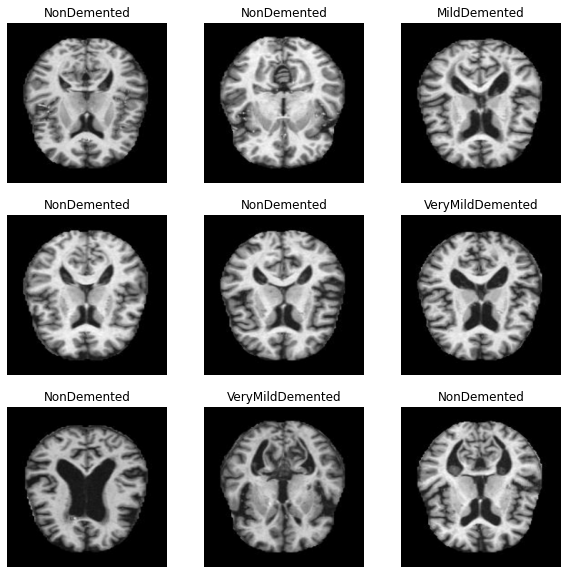

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [11]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [12]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [13]:
num_classes = len(class_names)# 7

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 4)                 2308      
                                                                 
Total params: 941,428
Trainable params: 2,308
Non-trainable p

In [15]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
161/161 [==============================] - 20s 63ms/step - loss: 1.0284 - accuracy: 0.5026 - val_loss: 0.9447 - val_accuracy: 0.5622
Epoch 2/10
161/161 [==============================] - 8s 48ms/step - loss: 0.9379 - accuracy: 0.5559 - val_loss: 0.9174 - val_accuracy: 0.5739
Epoch 3/10
161/161 [==============================] - 8s 47ms/step - loss: 0.9006 - accuracy: 0.5653 - val_loss: 0.9321 - val_accuracy: 0.5661


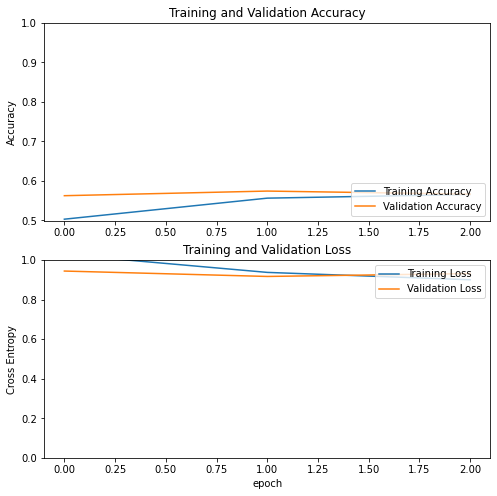

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 871ms/step


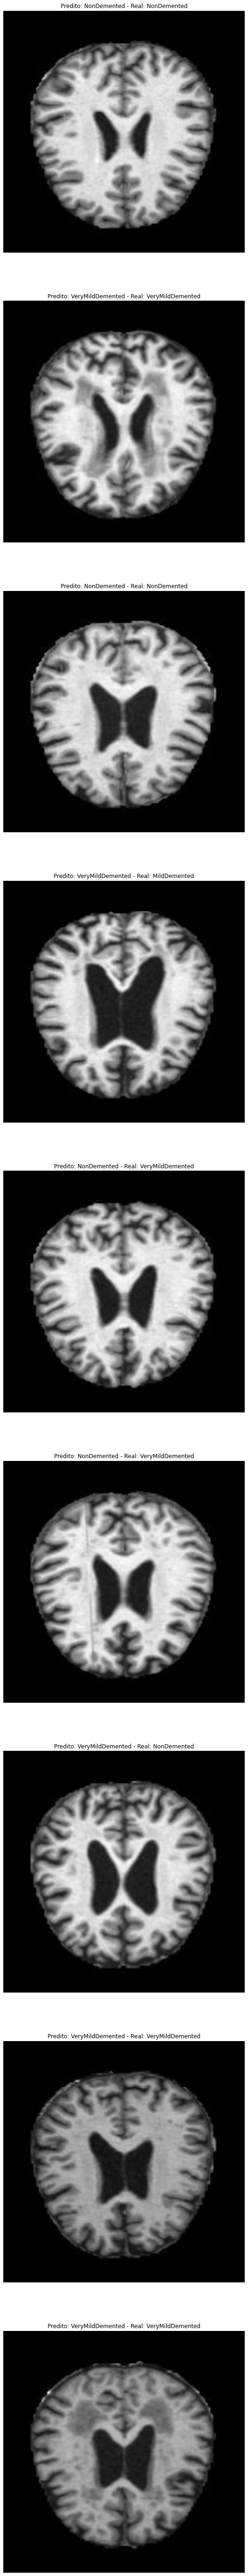

In [17]:
plt.figure(figsize=(10, 100))
for images, labels in val_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

In [18]:
#Visualize the result
results = model.evaluate(val_ds, verbose=0)

In [19]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.91741
Accuracy on the test set: 57.39%


In [20]:
model.save('/content/drive/MyDrive/Colab Notebooks/Alzheimer.h5')